In [9]:
import praw
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch
from tqdm import tqdm
from datetime import datetime
import time
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))


True
NVIDIA GeForce RTX 3060 Ti


In [3]:
# Use GPU if available
device = 0 if torch.cuda.is_available() else -1

# Sentiment pipeline setup
sentiment_model_name = "cardiffnlp/twitter-roberta-base-sentiment"
sentiment_tokenizer = AutoTokenizer.from_pretrained(sentiment_model_name)
sentiment_model = AutoModelForSequenceClassification.from_pretrained(sentiment_model_name)
sentiment_pipeline = pipeline("sentiment-analysis", model=sentiment_model, tokenizer=sentiment_tokenizer, device=device)
sentiment_label_map = {"LABEL_0": "Negative", "LABEL_1": "Neutral", "LABEL_2": "Positive"}


Device set to use cuda:0


In [4]:
# Emotion pipeline setup
emotion_model_name = "j-hartmann/emotion-english-distilroberta-base"
emotion_pipeline = pipeline("text-classification", model=emotion_model_name, tokenizer=emotion_model_name, top_k=1, device=device)


Device set to use cuda:0


In [5]:
# Reddit auth
reddit = praw.Reddit(
    client_id='q_dYyqYYdNNInGsM-lC9Xg',
    client_secret='pLigWA6vX6llH7NjWBhVWmg-gJjKvg',
    user_agent='script:gaming_trend (by /u/HiGhastlyy)',
    username='HiGhastlyy',
    password='0306terror'
)

In [15]:
subreddits = ['dota2', 'valorant', 'leagueoflegends', 'overwatch', 'fortnite','helldivers','assasinscreed','cs2','minecraft','monsterhunter']
years = list(range(2021, 2025))
max_posts = 1000
records = []

In [ ]:
# Scraping
for sub in subreddits:
    print(f"\n Scraping r/{sub} (limit={max_posts})...")
    submissions = list(reddit.subreddit(sub).top(time_filter='all', limit=1000))

    for post in tqdm(submissions, desc=f"Filtering r/{sub} posts"):
        post_time = datetime.utcfromtimestamp(post.created_utc)
        post_year = post_time.year
        if post_year not in years:
            continue

        post_text = f"{post.title} {post.selftext}".strip()
        if post_text:
            try:
                sentiment_result = sentiment_pipeline(post_text[:512])[0]
                sentiment = sentiment_label_map[sentiment_result['label']]
                sentiment_score = sentiment_result['score']
                emotion_result = emotion_pipeline(post_text[:512])[0][0]
                emotion = emotion_result['label']
                emotion_score = emotion_result['score']
            except:
                sentiment, sentiment_score = "Error", 0.0
                emotion, emotion_score = "Error", 0.0
        else:
            sentiment, sentiment_score = "N/A", 0.0
            emotion, emotion_score = "N/A", 0.0

        records.append({
            'type': 'post',
            'post_id': post.id,
            'comment_id': '',
            'parent_id': '',
            'subreddit': sub,
            'text': post_text,
            'score': post.score,
            'num_comments': post.num_comments,
            'created_utc': post.created_utc,
            'year': post_year,
            'sentiment': sentiment,
            'sentiment_confidence': round(sentiment_score, 3),
            'emotion': emotion,
            'emotion_confidence': round(emotion_score, 3)
        })

        try:
            post.comments.replace_more(limit=0)
            comments = post.comments.list()[:5]
        except:
            comments = []

        for comment in tqdm(comments, desc=f"  ↳ Top 5 comments for post {post.id}", leave=False):
            comment_text = comment.body.strip()
            if comment_text:
                try:
                    sentiment_result = sentiment_pipeline(comment_text[:512])[0]
                    sentiment = sentiment_label_map[sentiment_result['label']]
                    sentiment_score = sentiment_result['score']
                    emotion_result = emotion_pipeline(comment_text[:512])[0][0]
                    emotion = emotion_result['label']
                    emotion_score = emotion_result['score']
                except:
                    sentiment, sentiment_score = "Error", 0.0
                    emotion, emotion_score = "Error", 0.0
            else:
                sentiment, sentiment_score = "N/A", 0.0
                emotion, emotion_score = "N/A", 0.0

            records.append({
                'type': 'comment',
                'post_id': post.id,
                'comment_id': comment.id,
                'parent_id': comment.parent_id,
                'subreddit': sub,
                'text': comment_text,
                'score': comment.score,
                'num_comments': '',
                'created_utc': comment.created_utc,
                'year': datetime.utcfromtimestamp(comment.created_utc).year,
                'sentiment': sentiment,
                'sentiment_confidence': round(sentiment_score, 3),
                'emotion': emotion,
                'emotion_confidence': round(emotion_score, 3)
            })

        time.sleep(0.1)  # Light rate limit





⏳ Scraping r/dota2 (limit=1000)...


Filtering r/dota2 posts:   0%|          | 0/986 [00:00<?, ?it/s]C:\Users\Ghastly\AppData\Local\Temp\ipykernel_26104\3970901409.py:7: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  post_time = datetime.utcfromtimestamp(post.created_utc)
C:\Users\Ghastly\AppData\Local\Temp\ipykernel_26104\3970901409.py:78: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  'year': datetime.utcfromtimestamp(comment.created_utc).year,
Filtering r/dota2 posts: 100%|██████████| 986/986 [10:12<00:00,  1.61it/s]



⏳ Scraping r/valorant (limit=1000)...


Filtering r/valorant posts: 100%|██████████| 985/985 [20:12<00:00,  1.23s/it]



⏳ Scraping r/leagueoflegends (limit=1000)...


Filtering r/leagueoflegends posts: 100%|██████████| 987/987 [18:49<00:00,  1.14s/it]



⏳ Scraping r/overwatch (limit=1000)...


Filtering r/overwatch posts: 100%|██████████| 996/996 [06:56<00:00,  2.39it/s]



⏳ Scraping r/fortnite (limit=1000)...


Filtering r/fortnite posts: 100%|██████████| 999/999 [01:30<00:00, 11.05it/s]



⏳ Scraping r/helldivers (limit=1000)...


Filtering r/helldivers posts: 100%|██████████| 995/995 [38:34<00:00,  2.33s/it] 



⏳ Scraping r/assasinscreed (limit=1000)...


Filtering r/assasinscreed posts: 100%|██████████| 998/998 [02:45<00:00,  6.04it/s]



⏳ Scraping r/cs2 (limit=1000)...


Filtering r/cs2 posts: 100%|██████████| 997/997 [08:40<00:00,  1.91it/s]



⏳ Scraping r/minecraft (limit=1000)...


Filtering r/minecraft posts: 100%|██████████| 987/987 [14:03<00:00,  1.17it/s]



⏳ Scraping r/monsterhunter (limit=1000)...


Filtering r/monsterhunter posts: 100%|██████████| 991/991 [13:15<00:00,  1.25it/s]


In [33]:
# Build dataframe
df = pd.DataFrame(records)
print("✅ DataFrame shape:", df.shape)
print("✅ Columns:", df.columns.tolist())

✅ DataFrame shape: (18383, 14)
✅ Columns: ['type', 'post_id', 'comment_id', 'parent_id', 'subreddit', 'text', 'score', 'num_comments', 'created_utc', 'year', 'sentiment', 'sentiment_confidence', 'emotion', 'emotion_confidence']


In [42]:
# --- Compute sentiment value ---
def confidence_value(row):
    if row['sentiment'] == 'Positive':
        return row['sentiment_confidence']
    elif row['sentiment'] == 'Negative':
        return -row['sentiment_confidence']
    else:
        return 0.0

df['sentiment_value'] = df.apply(confidence_value, axis=1)

# --- UNWEIGHTED computation ---
unweighted_scores = df.groupby('post_id').agg({
    'sentiment_value': 'mean'
}).rename(columns={'sentiment_value': 'unweighted_sentiment_score'}).reset_index()

def label_unweighted(score):
    if score > 0.1:
        return "Unweighted Positive"
    elif score < -0.1:
        return "Unweighted Negative"
    else:
        return "Unweighted Neutral"

unweighted_scores['unweighted_sentiment_label'] = unweighted_scores['unweighted_sentiment_score'].apply(label_unweighted)

# --- WEIGHTED computation ---
df['weight'] = df['type'].apply(lambda t: 3 if t == 'post' else 1)
df['weighted_sentiment'] = df['sentiment_value'] * df['weight']

weighted_scores = df.groupby('post_id').apply(
    lambda group: pd.Series({
        'weighted_sentiment_score': group['weighted_sentiment'].sum() / group['weight'].sum()
    })
).reset_index()

def label_weighted(score):
    if score > 0.1:
        return "Weighted Positive"
    elif score < -0.1:
        return "Weighted Negative"
    else:
        return "Weighted Neutral"

weighted_scores['weighted_sentiment_label'] = weighted_scores['weighted_sentiment_score'].apply(label_weighted)

# Remove old sentiment columns if already merged before
df = df.drop(columns=[
    col for col in df.columns if col.startswith('unweighted_') or col.startswith('weighted_')
], errors='ignore')

# Merge new computed scores
df = df.merge(unweighted_scores, on='post_id', how='left')
df = df.merge(weighted_scores, on='post_id', how='left')


C:\Users\Ghastly\AppData\Local\Temp\ipykernel_26104\902987551.py:31: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_scores = df.groupby('post_id').apply(


In [43]:
df.to_csv("reddit_sentiment_weighted_unweighted_2021_2025_noNeut.csv", index=False)
print("\n Done! Saved with both weighted and unweighted sentiment scores.")


 Done! Saved with both weighted and unweighted sentiment scores.


In [48]:
# --- Summary Report ---

# Filter to only 'post' rows
posts_df = df[df['type'] == 'post'].copy()

print("\n Reddit Sentiment + Emotion Summary Report 📊")
print("-------------------------------------------------")
print(f"Total Posts Analyzed: {len(posts_df)}")
print()

# 1. Weighted Sentiment distribution
print(" Weighted Sentiment Distribution:")
print(posts_df['weighted_sentiment_label'].value_counts())
print()

# 2. Top 5 most positive posts (weighted)
print(" Top 5 Most Positive Posts (Weighted):")
top_positive = posts_df.sort_values('weighted_sentiment_score', ascending=False).head(5)
for i, row in top_positive.iterrows():
    print(f"- [{row['subreddit']}] Score: {row['weighted_sentiment_score']:.2f} | Title: {row['text'][:80]}...")
print()

# 3. Top 5 most negative posts (weighted)
print(" Top 5 Most Negative Posts (Weighted):")
top_negative = posts_df.sort_values('weighted_sentiment_score').head(5)
for i, row in top_negative.iterrows():
    print(f"- [{row['subreddit']}] Score: {row['weighted_sentiment_score']:.2f} | Title: {row['text'][:80]}...")
print()

# 4. Emotion distribution (just posts)
print(" Emotion Distribution (Posts Only):")
print(posts_df['emotion'].value_counts())
print()

# 5. Most common emotion per subreddit
print(" Most Common Emotion per Subreddit:")
common_emotions = posts_df.groupby('subreddit')['emotion'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else "N/A")
for subreddit, emotion in common_emotions.items():
    print(f"- {subreddit}: {emotion}")

# 6. Most common sentiment per subreddit (Weighted)
print(" Most Common Weighted Sentiment per Subreddit:")
common_sentiment = posts_df.groupby('subreddit')['weighted_sentiment_label'].agg(
    lambda x: x.mode().iloc[0] if not x.mode().empty else "N/A"
)
for subreddit, sentiment in common_sentiment.items():
    print(f"- {subreddit}: {sentiment}")



 Reddit Sentiment + Emotion Summary Report 📊
-------------------------------------------------
Total Posts Analyzed: 3091

 Weighted Sentiment Distribution:
weighted_sentiment_label
Weighted Positive    1139
Weighted Negative    1107
Weighted Neutral      845
Name: count, dtype: int64

 Top 5 Most Positive Posts (Weighted):
- [assasinscreed] Score: 0.98 | Title: Happy 2025!!! | "Good night and Joy be with You All"...
- [leagueoflegends] Score: 0.91 | Title: Arcane debuts Top 1 on Netflix TV Shows, reaches Top 1 in 38 countries Sources:
...
- [monsterhunter] Score: 0.89 | Title: Some MH illustration I made in 2022! Happy new year hunters!...
- [minecraft] Score: 0.88 | Title: A minecraft mural I made for my nephew. 😁...
- [valorant] Score: 0.87 | Title: ASTRA ART (took me forever ) I haven't seen any Astra art yet so I tried to draw...

 Top 5 Most Negative Posts (Weighted):
- [cs2] Score: -0.85 | Title: The crowd cheated and gave tabseN away...
- [valorant] Score: -0.84 | Title: Radia

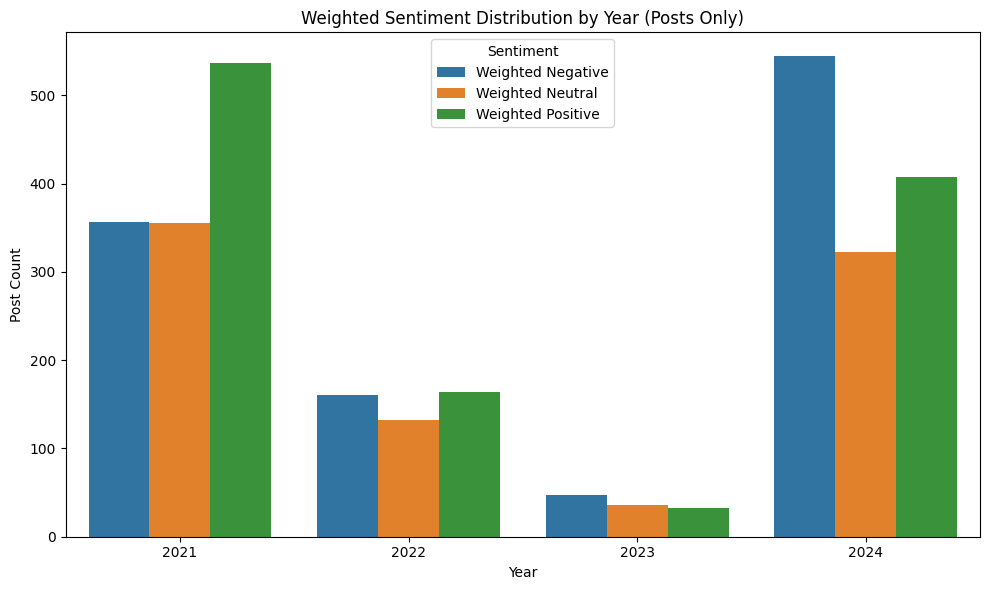

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by year and sentiment label
yearly = df[df['type'] == 'post'].groupby(['year', 'weighted_sentiment_label']).size().reset_index(name='count')

plt.figure(figsize=(10,6))
sns.barplot(data=yearly, x='year', y='count', hue='weighted_sentiment_label')
plt.title("Weighted Sentiment Distribution by Year (Posts Only)")
plt.ylabel("Post Count")
plt.xlabel("Year")
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()

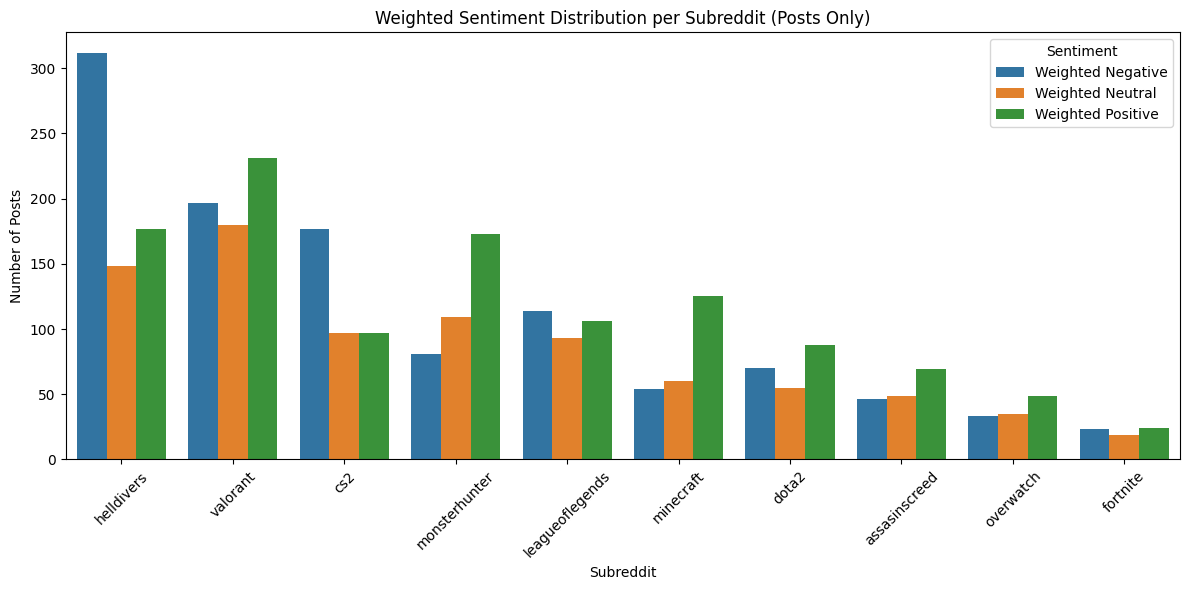

In [46]:
# Filter to posts only
posts_df = df[df['type'] == 'post'].copy()

# Prepare grouped data
subreddit_sentiment = posts_df.groupby(['subreddit', 'weighted_sentiment_label']).size().reset_index(name='count')

# Sort subreddits by total post count for better chart order
order = posts_df['subreddit'].value_counts().index.tolist()

plt.figure(figsize=(12, 6))
sns.barplot(data=subreddit_sentiment, x='subreddit', y='count', hue='weighted_sentiment_label', order=order)
plt.title("Weighted Sentiment Distribution per Subreddit (Posts Only)")
plt.ylabel("Number of Posts")
plt.xlabel("Subreddit")
plt.legend(title="Sentiment")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\Ghastly\AppData\Local\Temp\ipykernel_26104\4126819446.py:22: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
d:\School Files\ITS132L\redditwebscraping\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


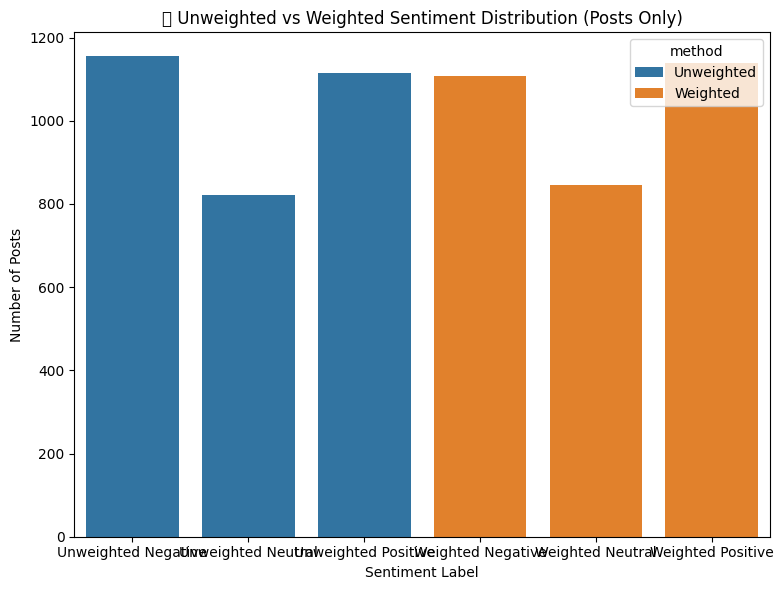

In [47]:
# Melt data for plotting
posts_df['method'] = 'Weighted'
unweighted_df = posts_df[['post_id', 'subreddit', 'unweighted_sentiment_label']].copy()
unweighted_df['method'] = 'Unweighted'
unweighted_df = unweighted_df.rename(columns={'unweighted_sentiment_label': 'sentiment_label'})

weighted_df = posts_df[['post_id', 'subreddit', 'weighted_sentiment_label']].copy()
weighted_df['method'] = 'Weighted'
weighted_df = weighted_df.rename(columns={'weighted_sentiment_label': 'sentiment_label'})

combined = pd.concat([unweighted_df, weighted_df])

# Count sentiment
comparison = combined.groupby(['method', 'sentiment_label']).size().reset_index(name='count')

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(data=comparison, x='sentiment_label', y='count', hue='method')
plt.title("📊 Unweighted vs Weighted Sentiment Distribution (Posts Only)")
plt.ylabel("Number of Posts")
plt.xlabel("Sentiment Label")
plt.tight_layout()
plt.show()

C:\Users\Ghastly\AppData\Local\Temp\ipykernel_26104\244912061.py:2: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df['year'] = df['created_utc'].apply(lambda x: datetime.utcfromtimestamp(x).year)


<Figure size 1400x800 with 0 Axes>

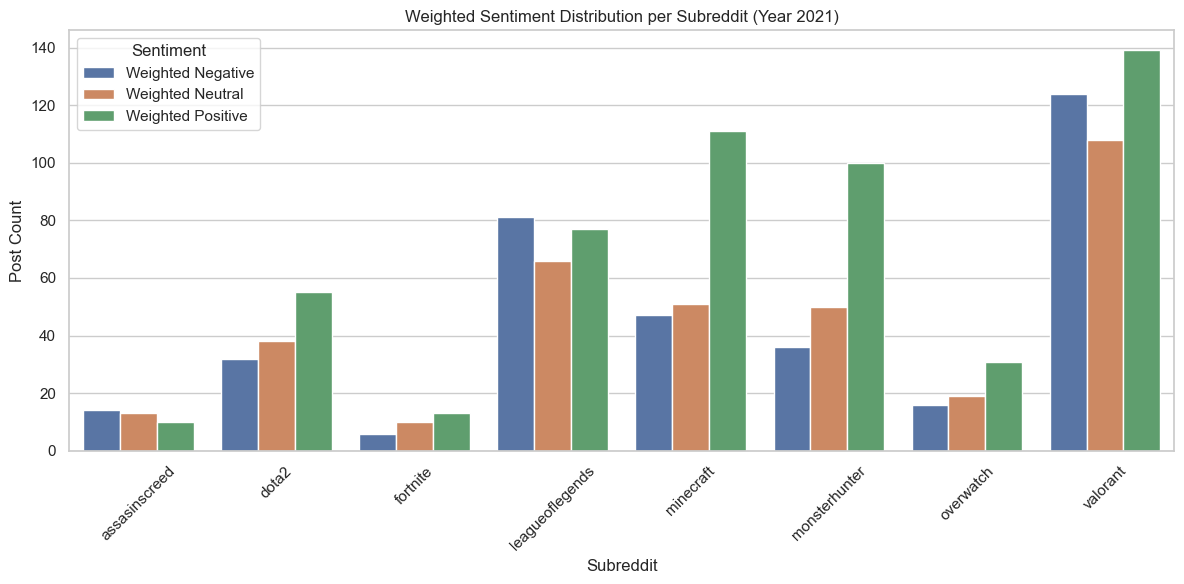

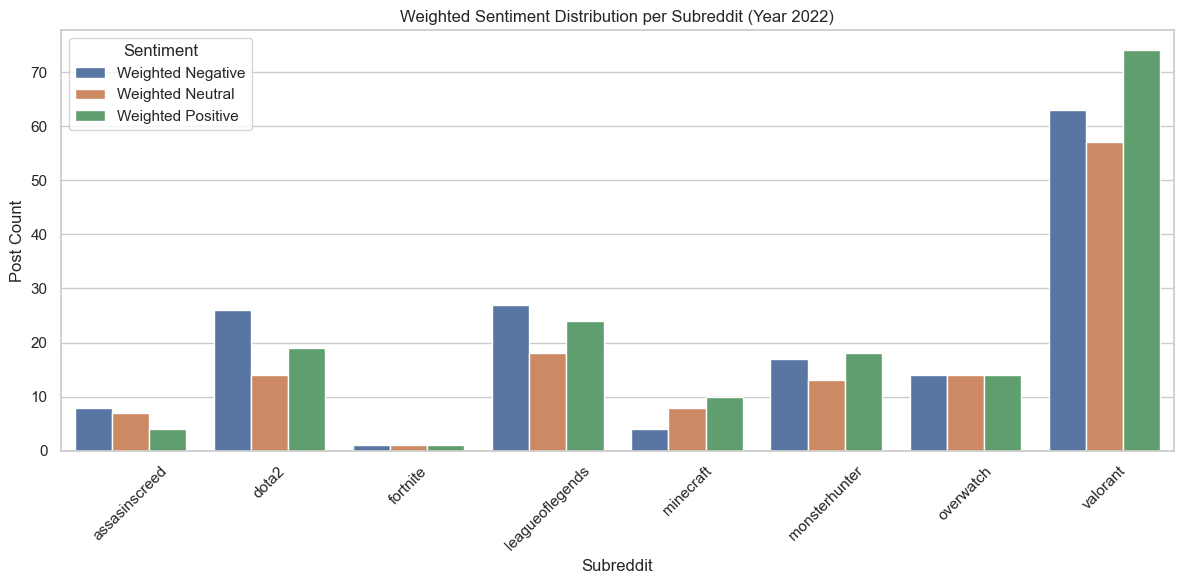

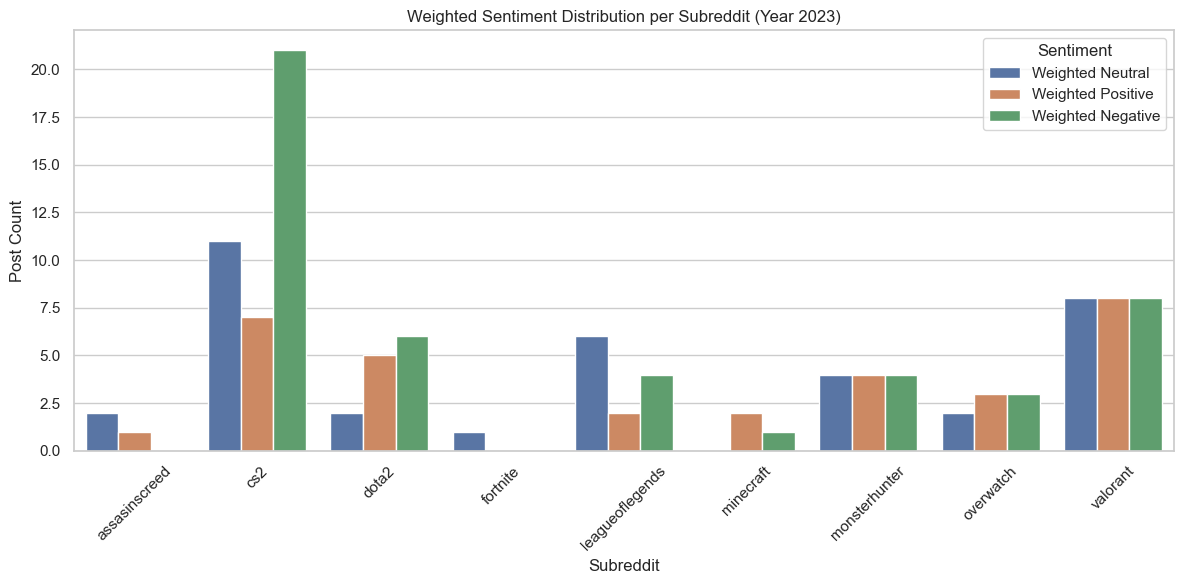

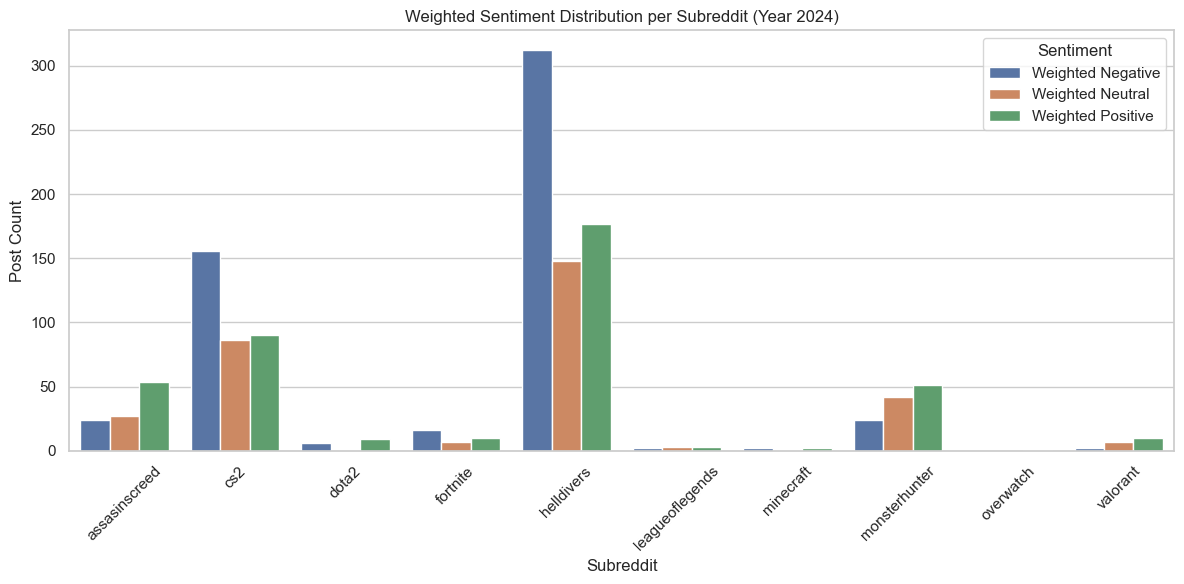

In [49]:
# Ensure the 'year' column is integer
df['year'] = df['created_utc'].apply(lambda x: datetime.utcfromtimestamp(x).year)

# Filter only post rows
posts_df = df[df['type'] == 'post'].copy()

# Count of sentiments per subreddit per year
grouped = posts_df.groupby(['subreddit', 'year', 'weighted_sentiment_label']).size().reset_index(name='count')

# Plot settings
plt.figure(figsize=(14, 8))
sns.set(style="whitegrid")

# Draw plot for each year
for year in sorted(grouped['year'].unique()):
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=grouped[grouped['year'] == year],
        x='subreddit',
        y='count',
        hue='weighted_sentiment_label'
    )
    plt.title(f'Weighted Sentiment Distribution per Subreddit (Year {year})')
    plt.xticks(rotation=45)
    plt.ylabel('Post Count')
    plt.xlabel('Subreddit')
    plt.legend(title='Sentiment')
    plt.tight_layout()
    plt.show()